# Create THERMOCALC KLB1 phase diagram

Import required libraries:

In [1]:
import pyMelt as m
from pyMelt import phaseDiagramTools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
klb1 = pd.read_csv('klb1_thermocalc_grid.csv')
klb1.head()

,Unnamed: 0,pressure,temperature,X,cpx,cpx_Al2O3,cpx_CaO,cpx_Cr2O3,cpx_FeO,cpx_K2O,...,g_SiO2,g_TiO2,g_xAlM2,g_xCaM1,g_xCrM2,g_xFe3M2,g_xFeM1,g_xMgM1,g_xMgM2,g_xTiM2
0,12124,0.01,1100.1,NaN,0.05621,0.856793,19.437163,0.271073,3.068039,0.132163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12125,0.01,1105.0,NaN,0.05591,0.864334,19.380258,0.271472,3.076061,0.132020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12126,0.01,1110.0,NaN,0.05560,0.872004,19.321117,0.271847,3.084343,0.131903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12127,0.01,1115.0,NaN,0.05527,0.879675,19.260842,0.272195,3.092751,0.131810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12128,0.01,1120.0,NaN,0.05494,0.887348,19.199420,0.272519,3.101241,0.131693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using lattice-strain model partition coefficients requires the pyrope proportion, which is more convenient to access directly:

In [11]:
# Properties needed to calculate garnet Ds
klb1['g_pyrope'] = klb1['g_xMgM1']
klb1['g_grossular'] = klb1['g_xCaM1'] - klb1['g_xCrM2'] - klb1['g_xFe3M2']
klb1['g_almandine'] = klb1['g_xFeM1']
klb1['g_uvarovite'] = klb1['g_xCrM2']
klb1['g_spessartine'] = 0.0
klb1['g_andradite'] = klb1['g_xFe3M2']

cols_to_sum = ['g_Al2O3', 'g_CaO', 'g_Cr2O3', 'g_FeO', 'g_K2O', 'g_MgO', 'g_Na2O', 'g_O', 'g_SiO2', 'g_TiO2']
g_totmass = klb1['g_Al2O3'] * m.chemistry.oxide_masses['Al2O3']

for col in cols_to_sum[1:]:
    g_totmass += klb1[col] * m.chemistry.oxide_masses[col[2:]]
    
klb1['g_FeO_wtpt'] = klb1['g_FeO'] * m.chemistry.oxide_masses['FeO'] / g_totmass * 100

# Properties needed for plagioclase Ds:
klb1['pl_anorthite'] = klb1['pl_x(Ca)']
klb1['pl_albite'] = klb1['pl_x(Na)']

# Properties needed for cpx Ds
klb1['liq_Mg#'] = klb1['liq_mgM'] / (klb1['liq_mgM'] + klb1['liq_feM'])

In [12]:
klb1_grid = phaseDiagramTools.gridsThermocalc(klb1)

In [13]:
parameters = ['ol_mass', 'g_mass', 'cpx_mass', 'opx_mass', 'spn_mass', 'pl_mass', 
              'liq_SiO2_wtpt', 'liq_MgO_wtpt', 'liq_FeO_wtpt', 'liq_Fe2O3_wtpt', 'liq_CaO_wtpt',
              'liq_Na2O_wtpt', 'liq_K2O_wtpt', 'liq_Cr2O3_wtpt', 'liq_Al2O3_wtpt', 'liq_TiO2_wtpt',
              'g_pyrope', 'g_grossular', 'g_almandine', 'g_uvarovite', 'g_spessartine', 'g_andradite', 'g_FeO_wtpt',
              'pl_anorthite', 'pl_albite',
              'liq_Mg#', 'cpx_xMgM1', 'cpx_xCaM2', 'cpx_xAlM1', 'temperature']
vars_edge_vals = ['g_pyrope', 'g_grossular', 'g_almandine', 'g_uvarovite', 'g_spessartine', 'g_andradite', 'g_FeO_wtpt',
                  'cpx_xMgM1', 'cpx_xCaM2', 'cpx_xAlM1', 'pl_anorthite', 'pl_albite']


In [14]:
phased = phaseDiagramTools.phaseDiagram(klb1_grid, parameters, vars_edge_vals=vars_edge_vals)

## Check the interpolated phase diagram

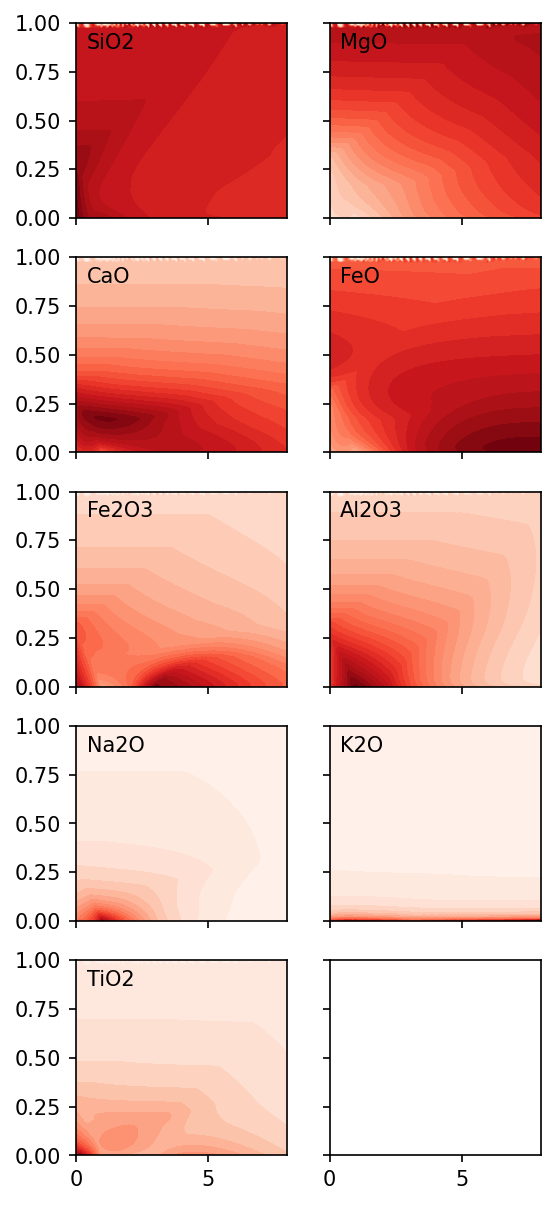

In [7]:
oxides = ['SiO2', 'MgO', 'CaO', 'FeO', 'Fe2O3', 'Al2O3', 'Na2O', 'K2O', 'TiO2']
p = np.linspace(0, 8, 100)
f = np.linspace(0, 1, 100)

pp, ff = np.meshgrid(p, f)

cc = np.zeros(np.shape(pp))

f, a = plt.subplots(5, 2, dpi=150, figsize=[4, 10], sharex='col', sharey='row')
a = np.ravel(a).tolist()


for n in range(len(oxides)):
    for i in range(np.shape(pp)[0]):
        for j in range(np.shape(pp)[1]):
            state = pd.Series({'P': pp[i,j],'F': ff[i,j]})
            cc[i,j] = phased('liq_' + oxides[n] + '_wtpt', state)
    
    a[n].contourf(pp, ff, cc, levels=25, cmap=plt.cm.Reds)
    a[n].text(0.05, 0.95, oxides[n], transform=a[n].transAxes, va='top', ha='left')

plt.show()

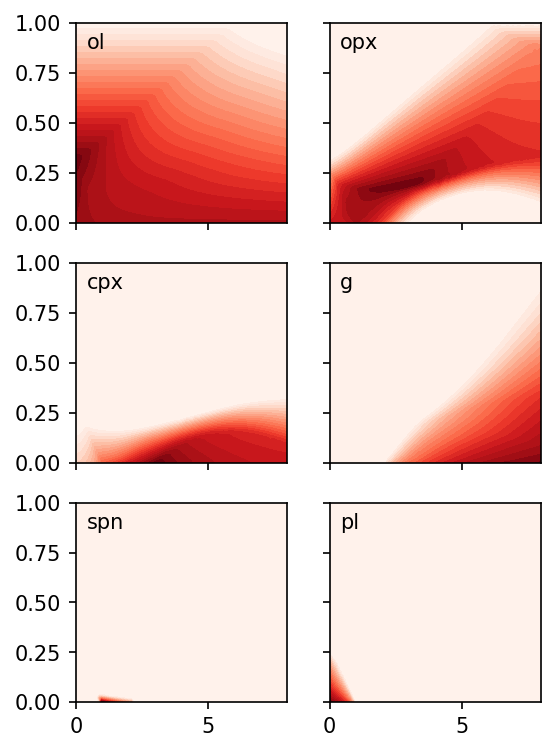

In [8]:
phases = ['ol', 'opx', 'cpx', 'g', 'spn', 'pl']
p = np.linspace(0, 8, 100)
f = np.linspace(0, 1, 100)

pp, ff = np.meshgrid(p, f)

cc = np.zeros(np.shape(pp))

f, a = plt.subplots(3, 2, dpi=150, figsize=[4, 6], sharex='col', sharey='row')
a = np.ravel(a).tolist()


for n in range(len(phases)):
    for i in range(np.shape(pp)[0]):
        for j in range(np.shape(pp)[1]):
            state = pd.Series({'P': pp[i,j],'F': ff[i,j]})
            cc[i,j] = phased(phases[n] + '_mass', state)
    
    a[n].contourf(pp, ff, cc, levels=25, cmap=plt.cm.Reds)
    a[n].text(0.05, 0.95, phases[n], transform=a[n].transAxes, va='top', ha='left')

plt.show()

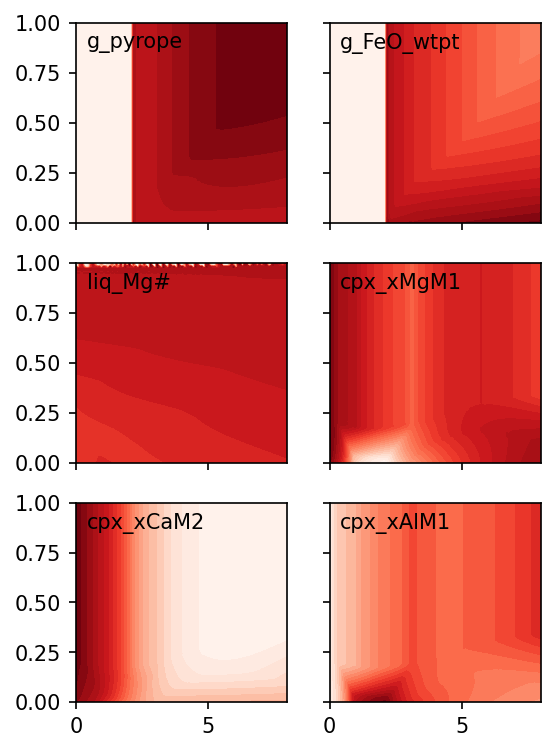

In [20]:
props = ['g_pyrope', 'g_FeO_wtpt', 'liq_Mg#', 'cpx_xMgM1', 'cpx_xCaM2', 'cpx_xAlM1']
p = np.linspace(0, 8, 100)
f = np.linspace(0, 1, 100)

pp, ff = np.meshgrid(p, f)

cc = np.zeros(np.shape(pp))

f, a = plt.subplots(3, 2, dpi=150, figsize=[4, 6], sharex='col', sharey='row')
a = np.ravel(a).tolist()


for n in range(len(props)):
    for i in range(np.shape(pp)[0]):
        for j in range(np.shape(pp)[1]):
            state = pd.Series({'P': pp[i,j],'F': ff[i,j]})
            cc[i,j] = phased(props[n], state)
    
    a[n].contourf(pp, ff, cc, levels=25, cmap=plt.cm.Reds)
    a[n].text(0.05, 0.95, props[n], transform=a[n].transAxes, va='top', ha='left')

plt.show()

In [15]:
f = open( "thermocalc_klb1.p", "wb" )
pickle.dump(phased, f)
f.close()